In [1]:
# Step 1: Import Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns

In [2]:
# Load MRI Dataset
import kagglehub

# # Download original dataset that is unbalanced
# path = kagglehub.dataset_download("matthewhema/mri-dementia-augmentation-no-data-leak")

# Download augmented dataset that is balanced
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/ingridblankevoort/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1


In [3]:
# Step 2: Define Parameters
image_size = (128, 128)
batch_size = 32
class_mode = 'categorical'
epochs = 20


In [4]:
# Step 3: Define Paths (update if needed)
train_dir = 'data_split_trainTest/train'
test_dir = 'data_split_trainTest/test'

In [5]:
# Step 4: Image Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False
)

Found 27187 images belonging to 4 classes.
Found 6797 images belonging to 4 classes.


In [11]:
# Step 5: Load Pretrained Model (ResNet50)
# Step 5: Build a Lightweight CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-15 19:23:45.374246: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-15 19:23:45.374273: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-05-15 19:23:45.374286: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1747358625.374306  113487 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747358625.374335  113487 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0

In [13]:
# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,052 (12.61 MB)

 Trainable params: 3,305,604 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
# Step 6: Train the Model
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/20


/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-15 19:24:28.096111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


850/850 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.2943 - loss: 18.5339 - val_accuracy: 0.3956 - val_loss: 1.4632 - learning_rate: 0.0010
Epoch 2/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.3527 - loss: 1.4428 - val_accuracy: 0.3999 - val_loss: 1.2105 - learning_rate: 0.0010
Epoch 3/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.3703 - loss: 1.4825 - val_accuracy: 0.3983 - val_loss: 1.2244 - learning_rate: 0.0010
Epoch 4/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.3660 - loss: 1.5817 - val_accuracy: 0.1973 - val_loss: 3.4895 - learning_rate: 0.0010
Epoch 5/20
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3736 - loss: 1.6533
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
850/850 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.3736 - loss: 1.6535 - val_accuracy: 0.3254 - val_loss: 1.8655 - learning_rate: 0.0010
Epoch 6/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.4027 - loss: 1.3414 

In [15]:
# Step 7: Evaluate the Model
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")


213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.55      0.72      0.62      1792
ModerateDemented       1.00      0.91      0.95      1293
     NonDemented       0.57      0.76      0.65      1920
VeryMildDemented       0.45      0.18      0.26      1792

        accuracy                           0.63      6797
       macro avg       0.64      0.64      0.62      6797
    weighted avg       0.62      0.63      0.60      6797

Weighted F1 Score: 0.5983


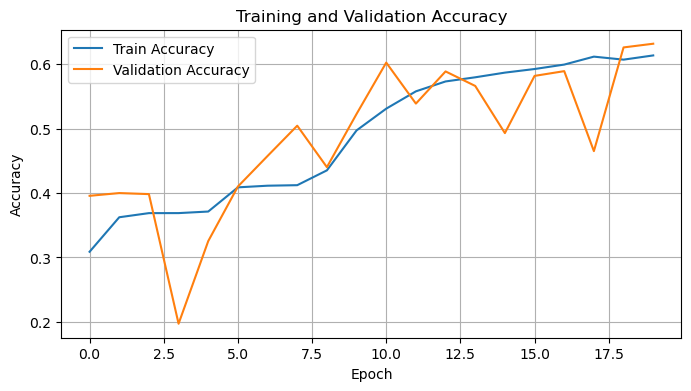

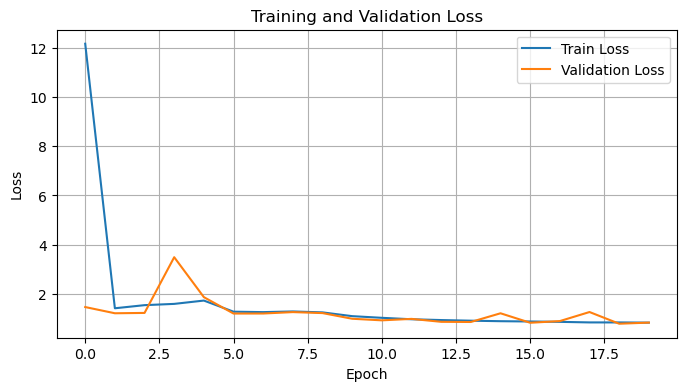

In [16]:
# Step 8: Visualize Training History

plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history.get('val_loss', []), label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

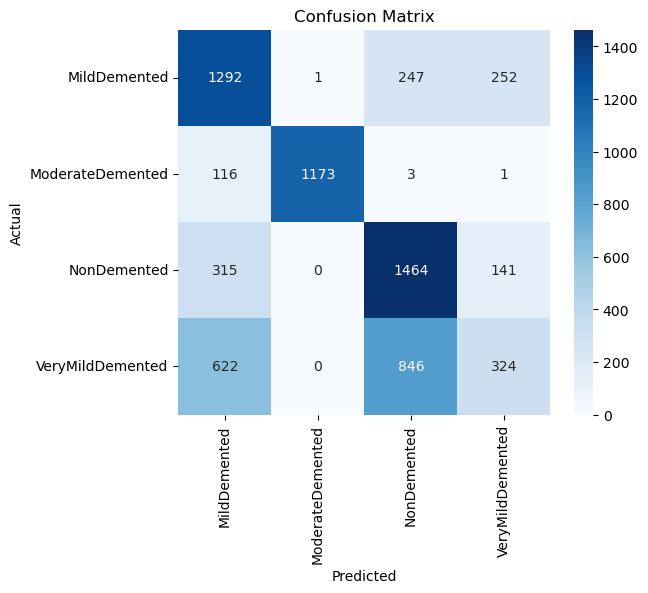

In [17]:
# Step 9: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Save the model and history into their respective files (keras and pickle)

In [21]:
# Create varibles to store the file names of the model and history 
model_name = model.name

# Set the version of the model    
version = 'V13'

model_fullfilename = 'dementia_cnn_' + model_name + '_model_' + version + '.keras'
history_fullfilename = 'dementia_cnn_' + model_name + '_history_' + version + '.pkl'

print(model_fullfilename)
print(history_fullfilename)

dementia_cnn_sequential_model_V13.keras
dementia_cnn_sequential_history_V13.pkl


In [22]:
# Save the model into an .keras file
model.save('saved_models/' + model_fullfilename)

# Save the history object into a pickle file
import pickle

with open('saved_models/' + history_fullfilename, 'wb') as file:
    pickle.dump(history.history, file)